<a href="https://colab.research.google.com/github/Dilhani98/Machine_Learning_project/blob/main/Anomoly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bitcoin-network-transactional-metadata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F424409%2F809022%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240218%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240218T162907Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2af3c87fdba72abc530d340ded66da8011854c245443b6e3cbefe983f7fc7f4fd0b13fd5a8f7a9196c3ac2a6ae757868bc3101b1379280c4b721b96d9d09e1ffb4d5e45cdffb9491e183fb3895c50a5388dc9b1332f4b7fa188527148b76a02a82b1452df2fdace22676f24ca83753ec1379e4700fe37b873224d86eac9df4f492790fa72251536fd29357ce8e6e1b03f698c0913ba89ec70e173377f92993c47fe4ac8b23ba0ff99acd3cc48855177c5961f2317bbf476e9a5eda693f6ff4b7184602f5771adb0def4e28e9eb059be07d6011ab0765eb4527bb7e408cf5d140e195e70a47f49127c800595df9a0c929de9a746a2a10222ba917261361a26244'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import countplot
from matplotlib.pyplot import figure, show
from scipy import stats
import warnings
import gc
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/kaggle/input/bitcoin-network-transactional-metadata/DG_out.csv',dtype={0:'object',1:'int64',2:'int64',3:'float64',4:'float64',5:'float64',6:'float64',7:'float64',8:'int64',9:'int64',10:'int64',11:'int64',12:'int64'})

In [ ]:
df.head()

,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,is_malicious,out_and_tx_malicious,all_malicious
0,0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...,0,1,0.000000,50.000000,50.000000,0.000000,50.000000,0,0,0,0,0
1,f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...,1,2,50.000000,50.000000,100.000000,50.000000,25.000000,0,0,0,0,0
2,ea44e97271691990157559d0bdd9959e02790c34db6c00...,1,1,10.000000,10.000000,20.000000,10.000000,10.000000,0,0,0,0,0
3,a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...,1,1,40.000000,30.000000,70.000000,40.000000,30.000000,0,0,0,0,0
4,591e91f809d716912ca1d4a9295e70c3e78bab077683f7...,1,2,30.000000,30.000000,60.000000,30.000000,15.000000,0,0,0,0,0


tx_hash: Hash of the bitcoin transaction.

indegree: Number of transactions that are inputs of tx_hash

outdegree: Number of transactions that are outputs of tx_hash.

in_btc: Number of bitcoins on each incoming edge to tx_hash.

out_btc: Number of bitcoins on each outgoing edge from tx_hash.

total_btc: Net number of bitcoins flowing in and out from tx_hash.

mean_in_btc: Average number of bitcoins flowing in for tx_hash.

mean_out_btc: Average number of bitcoins flowing out for tx_hash. 

in-malicious: Will be 1 if the tx_hash is an input of a malicious transaction.

out-malicious: Will be 1 if the tx_hash is an output of a malicious transaction.

is-malicious: Will be 1 if the tx_hash is a malicious transaction.

In [ ]:
df.shape

(30248134, 13)

In [ ]:
pd.options.display.float_format = '{:.3f}'.format
o_df = df.iloc[:,1:8]
o_df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc
count,30248134.000,30248134.000,30248134.000,30248134.000,30248134.000,30248134.000,30248134.000
mean,2.149,2.149,54.842,54.842,109.683,49.240,28.771
std,7.421,4.512,1303.303,1301.473,2602.527,972.921,712.557
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,2.000,0.100,0.099,0.206,0.064,0.050
50%,1.000,2.000,0.932,0.959,1.965,0.535,0.490
75%,2.000,2.000,8.592,9.064,18.400,5.614,4.519
max,1932.000,1322.000,550000.000,500020.700,1050000.000,499259.588,500000.000


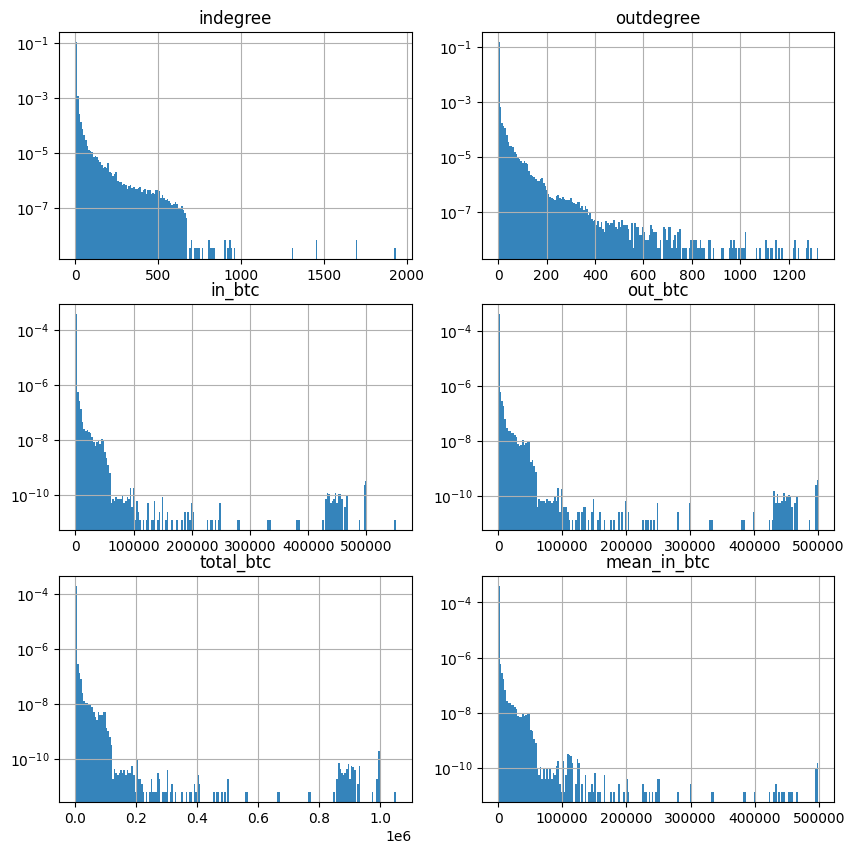

In [ ]:
def plot_distributions(df):
    c = 0
    bins = 200
    fig, ax = plt.subplots(3, 2, figsize=(10, 10))
    for i in range(3):
        for j in range(2):
            ax[i][j].hist(df.iloc[:,c], bins=bins, alpha=0.9, log=True, density=True)
            ax[i][j].title.set_text(df.columns[c])
            ax[i][j].grid()
            c = c+1
    plt.show()
# o_df.hist(figsize=(18, 20), bins=50, xlabelsize=9, ylabelsize=9, log=True);
plot_distributions(o_df)

In [ ]:
scaled_data = o_df.copy()
pd.options.display.float_format = '{:.3f}'.format

# Scale

In [ ]:
scaled_data['indegree'] = np.log1p(scaled_data['indegree'])
scaled_data['outdegree']= np.log1p(scaled_data['outdegree'])
scaled_data['in_btc'] = np.log1p(scaled_data['in_btc'])
scaled_data['out_btc']= np.log1p(scaled_data['out_btc'])
scaled_data['total_btc']= np.log1p(scaled_data['total_btc'])
scaled_data['mean_in_btc']= np.log1p(scaled_data['mean_in_btc'])
scaled_data['mean_out_btc']= np.log1p(scaled_data['mean_out_btc'])

scaled_data.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,is_malicious
count,29958371.000,30063879.000,30248134.000,30248134.000,30248134.000,30248134.000,30248134.000,30248134.000
mean,0.343,-0.045,0.145,0.144,0.084,0.208,0.197,0.000
std,0.498,0.219,0.481,0.478,0.484,0.490,0.492,0.002
min,0.000,-0.520,-0.363,-0.362,-0.496,-0.267,-0.275,0.000
25%,0.000,0.000,-0.301,-0.302,-0.391,-0.224,-0.237,0.000
50%,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000
75%,0.693,0.000,0.554,0.553,0.517,0.587,0.582,0.000
max,2.888,1.959,1.917,1.891,1.723,2.073,2.160,1.000


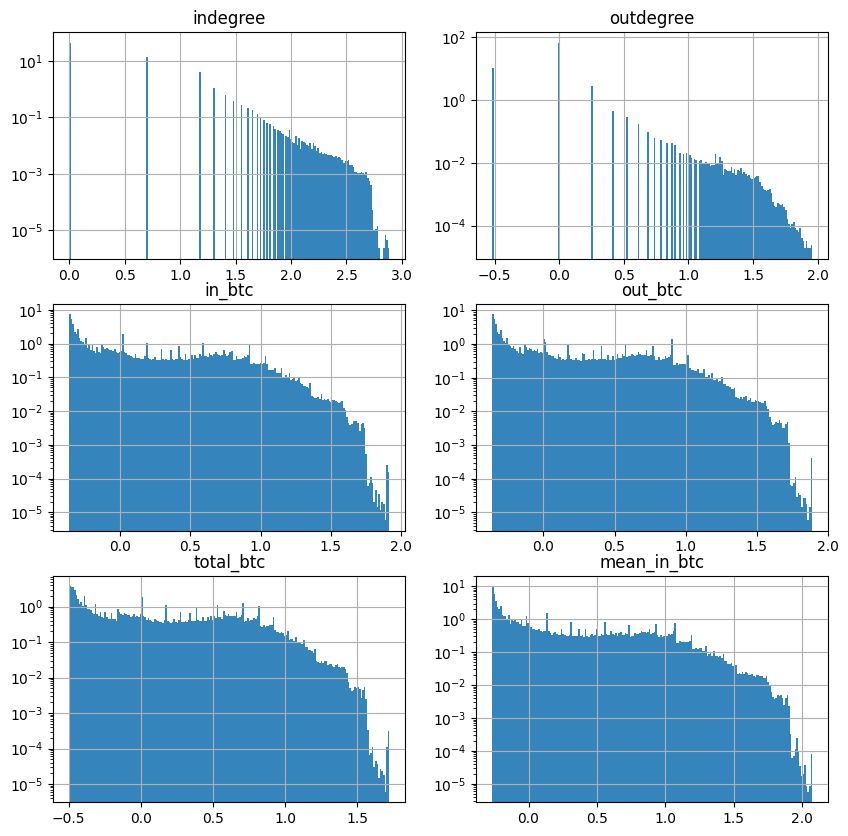

In [ ]:
# scaled_data.hist(figsize=(18, 20), bins=50, xlabelsize=9, ylabelsize=9, log=True);
plot_distributions(scaled_data)

# Normalize

In [ ]:
from sklearn.preprocessing import RobustScaler
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = RobustScaler()
# scaler = Normalizer(norm='l2')
# scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(scaled_data),columns=scaled_data.columns)
scaled_data.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,is_malicious
count,29958371.000,30063879.000,30248134.000,30248134.000,30248134.000,30248134.000,30248134.000,30248134.000
mean,0.495,-0.045,0.170,0.168,0.093,0.256,0.240,0.000
std,0.719,0.219,0.562,0.558,0.533,0.604,0.601,0.002
min,0.000,-0.520,-0.424,-0.423,-0.547,-0.329,-0.336,0.000
25%,0.000,0.000,-0.352,-0.353,-0.431,-0.276,-0.289,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1.000,0.000,0.648,0.647,0.569,0.724,0.711,0.000
max,4.166,1.959,2.241,2.209,1.898,2.555,2.639,1.000


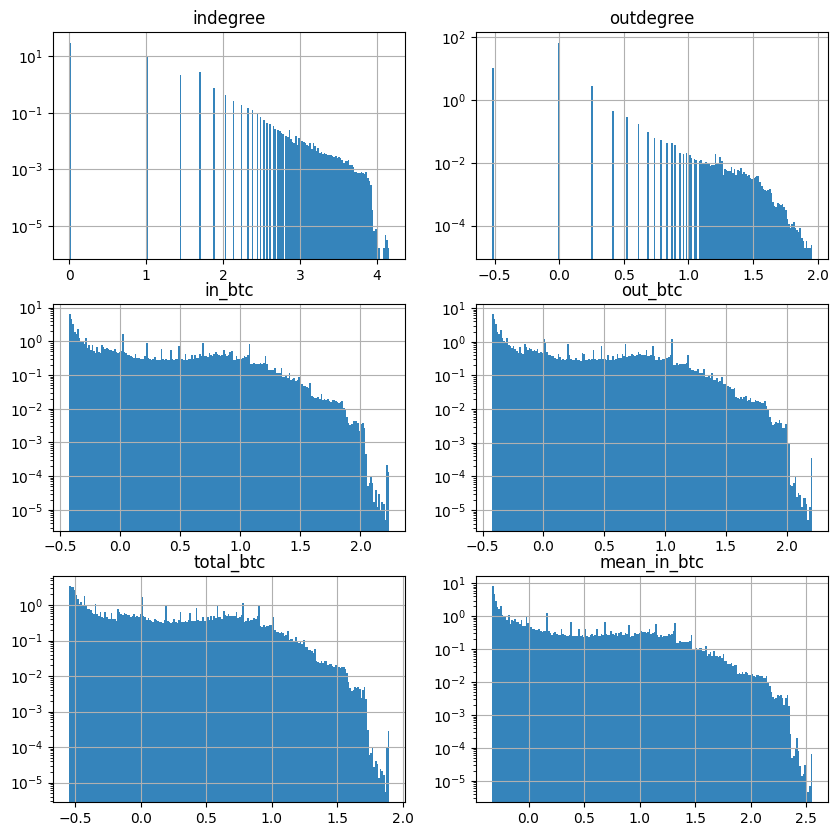

In [ ]:
plot_distributions(scaled_data)

In [ ]:
scaled_data['is_malicious'] = df['out_and_tx_malicious']

In [ ]:
scaled_data.head(5)

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,is_malicious
0,-1.710,-0.405,-0.304,1.472,1.024,-0.235,2.129,0
1,0.000,0.000,1.511,1.472,1.270,1.917,1.723,0
2,0.000,-0.405,0.803,0.779,0.705,1.078,1.205,0
3,0.000,-0.405,1.411,1.247,1.143,1.798,1.829,0
4,0.000,0.000,1.281,1.247,1.089,1.645,1.431,0


# Class Distribution

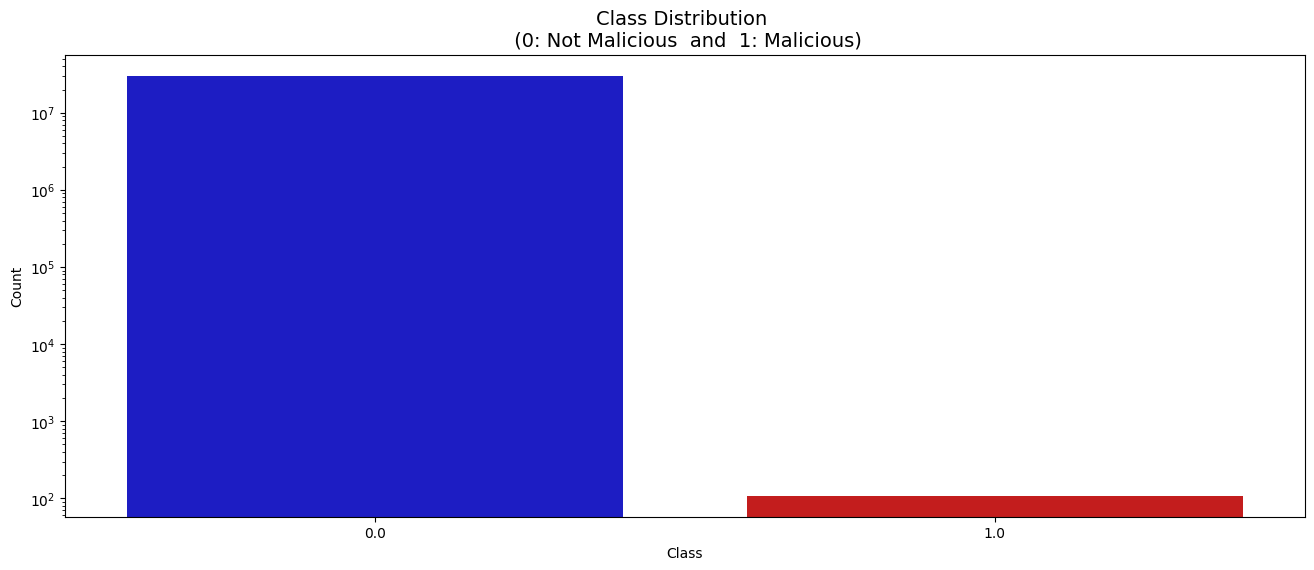

In [ ]:
colors = ["#0101DF", "#DF0101"]
# Plot the countplot using the scaled DataFrame
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='is_malicious', data=scaled_data, palette=colors, log ='True')
plt.title('Class Distribution \n (0: Not Malicious  and  1: Malicious)', fontsize=14)
ax.set(xlabel='Class', ylabel='Count')
plt.show()

In [ ]:
scaled_data.is_malicious.value_counts()


is_malicious
0    30248026
1         108
Name: count, dtype: int64

# Correlation Visual

In [ ]:
fraud_df = scaled_data.loc[scaled_data['is_malicious'] == 1]
non_fraud_df = scaled_data.loc[scaled_data['is_malicious'] == 0].sample(len(fraud_df))
new_df = pd.concat([fraud_df, non_fraud_df])
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))

# Entire DataFrame
corr = scaled_data.iloc[:,0:7].corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax1)
ax1.set_title("Correlation Matrix", fontsize=14)


sub_sample_corr = new_df.iloc[:,0:7].corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':10}, ax=ax2)
ax2.set_title('Sub-Sample Correlation Matrix', fontsize=14)
plt.show()

Negative Correlations: indegree, outdegree negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

Positive Correlations: in_btc, mean_in_btc, out_btc, mean_out_btc and total_btc are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

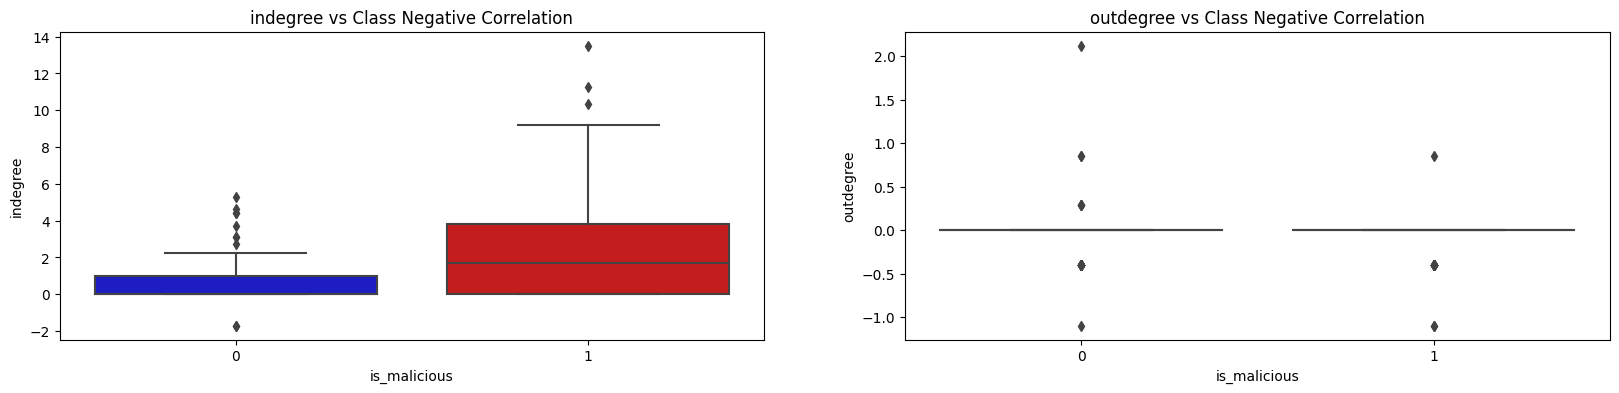

In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="is_malicious", y="indegree", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('indegree vs Class Negative Correlation')

sns.boxplot(x="is_malicious", y="outdegree", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('outdegree vs Class Negative Correlation')

plt.show()

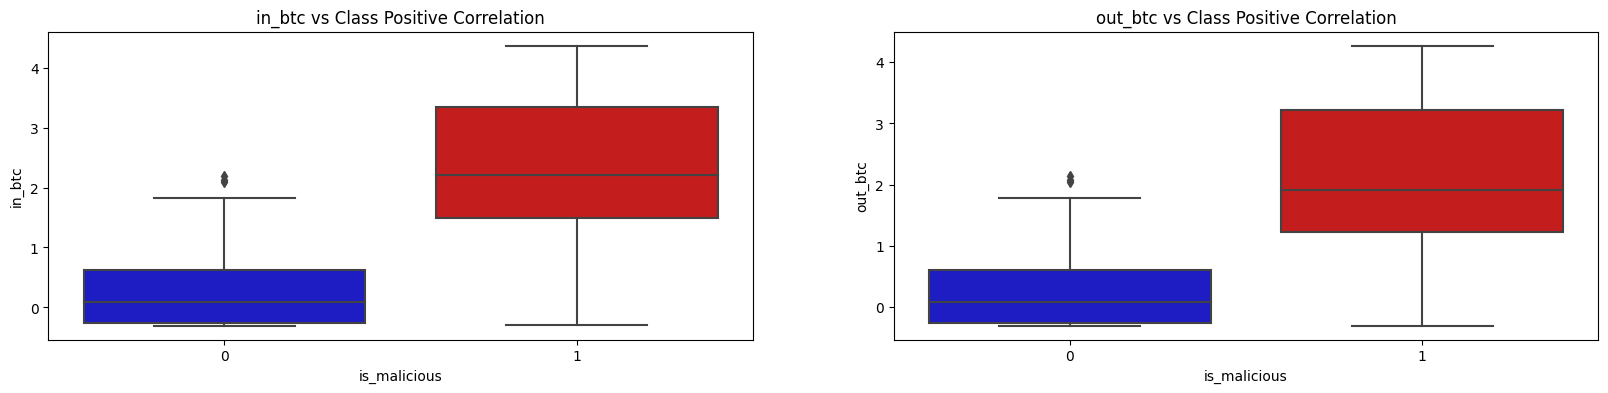

In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="is_malicious", y="in_btc", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('in_btc vs Class Positive Correlation')

sns.boxplot(x="is_malicious", y="out_btc", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('out_btc vs Class Positive Correlation')

plt.show()


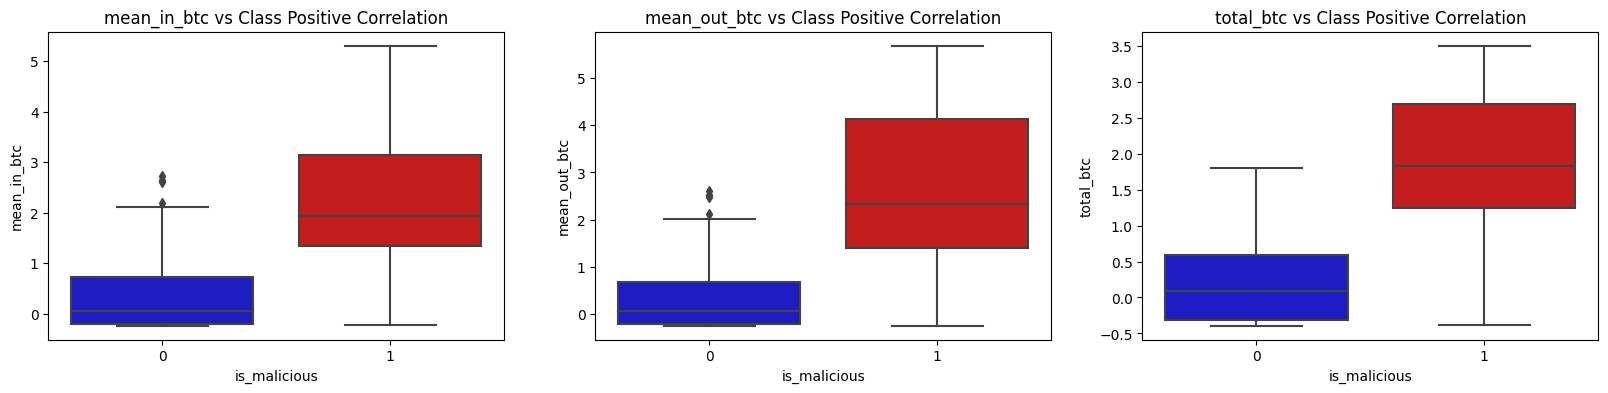

In [ ]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)

sns.boxplot(x="is_malicious", y="mean_in_btc", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('mean_in_btc vs Class Positive Correlation')

sns.boxplot(x="is_malicious", y="mean_out_btc", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('mean_out_btc vs Class Positive Correlation')

sns.boxplot(x="is_malicious", y="total_btc", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('total_btc vs Class Positive Correlation')

plt.show()

# Split Dataset